# Modeling for Prediction

We explore how we can build a model using available data with the intent of predicting a response/outcome with new data

![modeling_prediction.png](images/modeling_prediction.png)

Here, the selection of covariates is guided by the prediction accuracy on new data (actual or inferred)
- the coefficients give an indication of which covariates are important for the prediction
- the coefficients are **not meant** to explain the effect size on the outcome

---
## Data preparation

We will use the dataset from the Framingham study, which was a long term study of cardiovascular disease about subjsects in Framingham, USA. In this dataset ~4000 subjects were followed up and clinical data and chronic heart disease outcomes were examined longitudinally over > 10 years

Variables include:
- `male` : 0 = female, 1 = male
- `age` : Age at the time of medical examination in years.
- `education` : 1 = Some high school, 2 = high school/GED, 3 = some college/vocational school, 4 = college
- `currentSmoker`: Current cigarette smoking at the time of examinations
- `cigsPerDay`: Number of cigarettes smoked each day
- `BPmeds`: Use of Anti-hypertensive medication at exam
- `prevalentStroke`: Prevalent Stroke 
- `prevalentHyp`: Prevalent Hypertensive
- `diabetes`: Diabetic according to criteria of first exam treated
- `totChol`: Total cholesterol (mg/dL)
- `sysBP`: Systolic Blood Pressure (mmHg)
- `diaBP`: Diastolic blood pressure (mmHg)
- `BMI`: Body Mass Index, weight (kg)/height (m)^2
- `heartRate`: Heart rate (beats/minute)
- `glucose`: Blood glucose level (mg/dL)

In [1]:
library(tidyverse)

# read data
data<- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# rename and change data types
data <- data %>%
        rename(sex = male) %>%
        mutate(sex = as.factor(sex)) %>%
        mutate(education = as.factor(education)) %>%
        mutate(currentSmoker = as.factor(currentSmoker)) %>%
        mutate(BPMeds = as.factor(BPMeds)) %>%
        mutate(prevalentStroke = as.factor(prevalentStroke)) %>%
        mutate(prevalentHyp = as.factor(prevalentHyp)) %>%
        mutate(diabetes = as.factor(diabetes)) %>%
        mutate(TenYearCHD = as.factor(TenYearCHD))

# drop missing values
data <- data %>% drop_na

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 4240 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (16): male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We will choose a subset of variables and find a model to predict the systolic BP `sysBP` from a combination of these variables

In [2]:
data_subset <- data %>%
               filter(BPMeds==0) %>%
               select(-TenYearCHD, -prevalentStroke, -prevalentHyp, -diaBP, -currentSmoker, -BPMeds)

head(data_subset)

sex,age,education,cigsPerDay,diabetes,totChol,sysBP,BMI,heartRate,glucose
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,39,4,0,0,195,106.0,26.97,80,77
0,46,2,0,0,250,121.0,28.73,95,76
1,48,1,20,0,245,127.5,25.34,75,70
0,61,3,30,0,225,150.0,28.58,65,103
0,46,3,23,0,285,130.0,23.10,85,85
0,43,2,0,0,228,180.0,30.30,77,99


---
## Predicting systolic BP as an example

In predictive modeling, we would like to achieve the lowest prediction error on an out-of-sample dataset that was not used to build the model

We will explore this idea by splitting the dataset into training and test sets
- The training dataset will be used to build models with different parameters (covariates)
- The model will be used to predict the systolic BP based on the model parameters (covariates)

![predict_train_test.png](images/predict_train_test.png)

We will use the `initial_split`, `training` and `testing` functions from the `tidymodels` library
- Define the proportion of the split: `initial_split(data, prop = <proportion of training split>)`
- Generate the training and testing datasets: `training(<initial_split data>)` and `testing(<initial_split data>)`

In [3]:
library(tidymodels)

set.seed(246) # for reproducibility

data_subset_split <- initial_split(data_subset, prop = 3/4) # 3/4 training data
data_subset_train <- training(data_subset_split)
data_subset_test <- testing(data_subset_split)

head(data_subset_train)
head(data_subset_test)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org



sex,age,education,cigsPerDay,diabetes,totChol,sysBP,BMI,heartRate,glucose
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,46,3,0,0,305,150.0,26.82,75,75
0,53,3,20,0,221,131.0,24.09,90,95
0,59,3,0,0,240,149.0,27.48,80,82
0,40,4,3,0,230,107.5,26.38,75,76
0,61,2,0,0,255,114.0,24.79,83,107
0,43,1,0,0,229,124.0,30.28,72,77


sex,age,education,cigsPerDay,diabetes,totChol,sysBP,BMI,heartRate,glucose
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,63,1,0,0,205,138,33.11,60,85
0,45,2,20,0,313,100,21.68,79,78
1,43,1,30,0,225,162,23.61,93,88
1,41,2,0,0,195,139,26.88,85,65
0,52,1,0,0,234,148,34.17,70,113
1,35,2,20,0,225,132,26.09,73,83


We will build different models with combinations of covariates on the training dataset `data_subset_train`. Note that the `.` notation is a short form for all covariates

In [4]:
model1 <- lm(sysBP ~ age, data_subset_train)
model2 <- lm(sysBP ~ age + sex, data_subset_train)
model3 <- lm(sysBP ~ age + sex + education, data_subset_train)
model4 <- lm(sysBP ~ age + sex + education + glucose, data_subset_train)
model5 <- lm(sysBP ~ age + sex + glucose, data_subset_train)
model6 <- lm(sysBP ~ age + sex + glucose + BMI, data_subset_train)
model7 <- lm(sysBP ~ age + sex + totChol + BMI + heartRate + glucose, data_subset_train)
model8 <- lm(sysBP ~ ., data_subset_train)

We can look at the $R^2$ fit for the models by extracting it from the fitted model
- `summary(model)$r.squared`

In [5]:
# collect r2 values for all 8 models

r2_fit <- tibble(
            model=1:8,
            formula=c(model1$call$formula, # extract formula
                      model2$call$formula,
                      model3$call$formula,
                      model4$call$formula,
                      model5$call$formula,
                      model6$call$formula,
                      model7$call$formula,
                      model8$call$formula),
            r2=c(summary(model1)$r.squared, # extract r2
                 summary(model2)$r.squared,
                 summary(model3)$r.squared,
                 summary(model4)$r.squared,
                 summary(model5)$r.squared,
                 summary(model6)$r.squared,
                 summary(model7)$r.squared,
                 summary(model8)$r.squared)
             ) %>%
           mutate(model=as.factor(model),
                  formula=as.character(formula))

r2_fit

model,formula,r2
<fct>,<chr>,<dbl>
1,sysBP ~ age,0.1413048
2,sysBP ~ age + sex,0.1414696
3,sysBP ~ age + sex + education,0.1448863
4,sysBP ~ age + sex + education + glucose,0.1520279
5,sysBP ~ age + sex + glucose,0.1487736
6,sysBP ~ age + sex + glucose + BMI,0.2274826
7,sysBP ~ age + sex + totChol + BMI + heartRate + glucose,0.2593385
8,sysBP ~ .,0.2611845


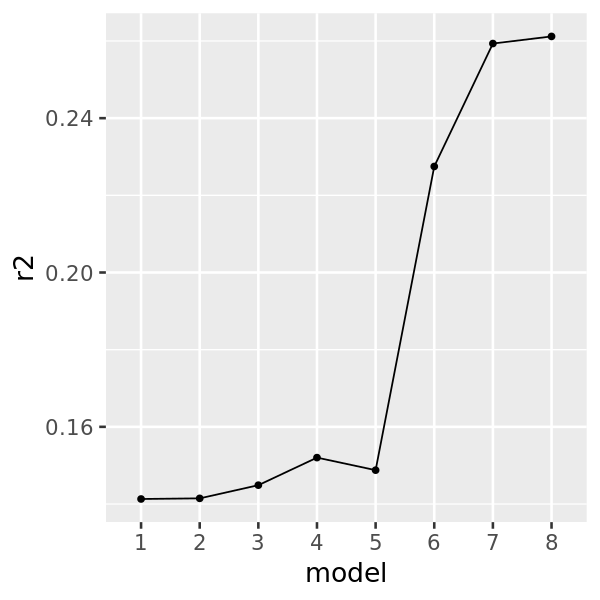

In [6]:
# adjust size of the image output
options(repr.plot.width=5, repr.plot.height=5)

r2_fit %>% ggplot(aes(x=model, y=r2, group=1)) +
           geom_line() +
           geom_point() +
           theme_grey(base_size=16)

It appears that the model with all the covariates `(sysBP ~ .)` would give the best fit based on the highest $R^2$ value. 
- The $R^2$ shows that the model explains at best ~20% of the variation in the dataset
- The highest $R^2$ does not mean that the model has the best ability to predict on  out-of-sample data

---
### Predicting on hold-out test dataset

To evaluate whether the model is able to predict using out-of-sample data, we will use the test dataset `data_subset_test` and use the `predict` function to calculate the predicted `sysBP` values from the covariates in the test data
- `predict(<model>, <test dataset>)`

In [7]:
predict1 <- predict(model1, data_subset_test)
predict2 <- predict(model2, data_subset_test)
predict3 <- predict(model3, data_subset_test)
predict4 <- predict(model4, data_subset_test)
predict5 <- predict(model5, data_subset_test)
predict6 <- predict(model6, data_subset_test)
predict7 <- predict(model7, data_subset_test)
predict8 <- predict(model8, data_subset_test)

We will look at a sample of one of the prediction sets `predict1`

In [8]:
tibble(data_subset_test, predict=predict1) %>% head()

sex,age,education,cigsPerDay,diabetes,totChol,sysBP,BMI,heartRate,glucose,predict
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,63,1,0,0,205,138,33.11,60,85,144.0469
0,45,2,20,0,313,100,21.68,79,78,127.3206
1,43,1,30,0,225,162,23.61,93,88,125.4621
1,41,2,0,0,195,139,26.88,85,65,123.6037
0,52,1,0,0,234,148,34.17,70,113,133.8253
1,35,2,20,0,225,132,26.09,73,83,118.0282


To gauge how close the predictions are to the actual values in the test dataset, we can calculate the root mean squared error (RMSE)

$$
\mathit{RMSE} = \sqrt{(\mathit{predicted}-\mathit{observed})^2}
$$

We can use the `RMSE` function from the `caret` library
- `RMSE(<predict data>, <observed data>` where the observed data is the `sysBP` variable in `data_subset_test`

In [9]:
library(caret)

# collect RMSE results for all 8 models from test dataset

test_fit <- tibble(model=1:8,
                  formula=c(model1$call$formula, # extract formula
                            model2$call$formula,
                            model3$call$formula,
                            model4$call$formula,
                            model5$call$formula,
                            model6$call$formula,
                            model7$call$formula,
                            model8$call$formula),
                   RMSE=c(RMSE(predict1, data_subset_test$sysBP), # extract RMSE
                          RMSE(predict2, data_subset_test$sysBP),
                          RMSE(predict3, data_subset_test$sysBP),
                          RMSE(predict4, data_subset_test$sysBP),
                          RMSE(predict5, data_subset_test$sysBP),
                          RMSE(predict6, data_subset_test$sysBP),
                          RMSE(predict7, data_subset_test$sysBP),
                          RMSE(predict8, data_subset_test$sysBP))) %>%
           mutate(model=as.factor(model),
                  formula=as.character(formula))

test_fit

Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity


The following object is masked from ‘package:purrr’:

    lift




model,formula,RMSE
<fct>,<chr>,<dbl>
1,sysBP ~ age,19.92564
2,sysBP ~ age + sex,19.90763
3,sysBP ~ age + sex + education,19.83316
4,sysBP ~ age + sex + education + glucose,19.85367
5,sysBP ~ age + sex + glucose,19.92666
6,sysBP ~ age + sex + glucose + BMI,18.96923
7,sysBP ~ age + sex + totChol + BMI + heartRate + glucose,18.72770
8,sysBP ~ .,18.74517


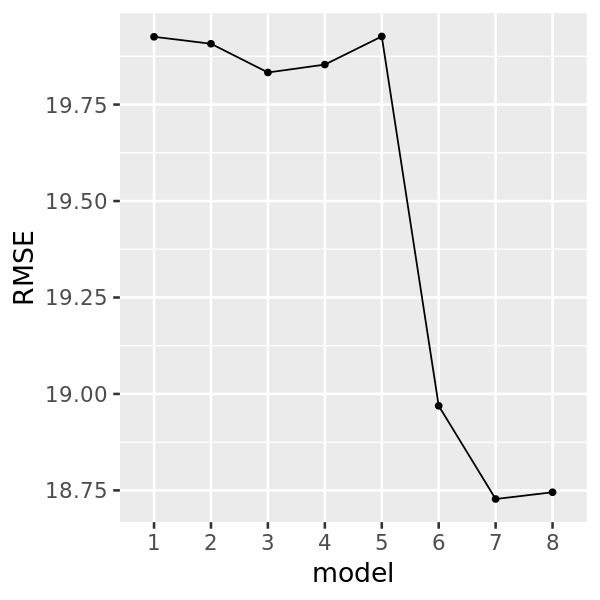

In [10]:
# adjust size of the image output
options(repr.plot.width=5, repr.plot.height=5)

test_fit %>% ggplot(aes(x=model, y=RMSE, group=1)) +
               geom_line() +
               geom_point() +
               theme_grey(base_size=16)

We can see that `model7` gives the lowest RMSE, indicating that it has the lowest error when predicting the sysBP on the hold-out test dataset that was not used for building the model. 
- It suggests that `model7` has higher generalizability on other unseen datasets
- The model with the best fit $R^2$ (`model8`) is not necessarily the one with the lowest prediction error

#### Problem of overfitting

As you can see, adding more covariates may not necessarily give the best prediction accuracy for out-of-sample data
- The addition of covariates will increase the model fit for the training data
- However, the model may overfit (i.e. learn patterns that are specific for the training data)
- Overfitting will reduce the ability for the model to predict well on new unseen samples

![predict_overfitting.png](images/predict_overfitting.png)

---
### Gauging out-of-sample performance with data at hand

#### 1. K-fold cross validation

In some cases, we may not have enough data at hand to be able to split them into training and test datasets in order to evaluate which model would have the best predictive performance

We can gauge out-of-sample prediction performance by using **all** the data at hand `data_subset` by using a cross-validation approach
- The dataset is shuffled randomly and split into $k$ groups
- For each of the $k^\mathit{th}$ group
  - Use the $k^\mathit{th}$ group as the hold-out test dataset
  - Use the remaining data of $k - 1$ groups as the training dataset
  - Fit the model and use it to predict the $k^\mathit{th}$ test dataset
  - Evaluate the prediction error 
- Evaluate the average prediction error for the $k$ groups for the model

![predict_kfold.png](images/predict_kfold.png)

To do this, we will use the `trainControl` and `train` functions fro the `caret` library
- We specify the cross validation and number of $k$ folds: `trainControl(method = "cv", number = <k-folds>)`
- We train the cross validation dataset: `train(<formula>, dataset, method="lm", trControl = <trainControl specification>)`

In [11]:
set.seed(246) # for reproducibility

# set the cross validation (10-fold)

train.control <- trainControl(method = "cv", number = 10)

# train the different models

model1_cv <- train(sysBP ~ age, 
                   data = data_subset, 
                   method = "lm",
                   trControl = train.control)
model2_cv <- train(sysBP ~ age + sex, 
                   data = data_subset, 
                   method = "lm",
                   trControl = train.control)
model3_cv <- train(sysBP ~ age + sex + education, 
                   data = data_subset, 
                   method = "lm",
                   trControl = train.control)
model4_cv <- train(sysBP ~ age + sex + education + glucose, 
                   data = data_subset, 
                   method = "lm",
                   trControl = train.control)
model5_cv <- train(sysBP ~ age + sex + glucose, 
                   data = data_subset, 
                   method = "lm",
                   trControl = train.control)
model6_cv <- train(sysBP ~ age + sex + glucose + BMI, 
                   data = data_subset, 
                   method = "lm",
                   trControl = train.control)
model7_cv <- train(sysBP ~ age + sex + totChol + BMI + heartRate + glucose, 
                   data = data_subset, 
                   method = "lm",
                   trControl = train.control)
model8_cv <- train(sysBP ~ ., 
                   data = data_subset, 
                   method = "lm",
                   trControl = train.control)

We can check the prediction error by looking at the `RMSE`

In [12]:
# collect RMSE results for all 8 models from 10-fold CV of full dataset

cv_fit <- tibble(
            model=1:8,
            formula=c(model1_cv$call$form, # extract formula
                      model2_cv$call$form,
                      model3_cv$call$form,
                      model4_cv$call$form,
                      model5_cv$call$form,
                      model6_cv$call$form,
                      model7_cv$call$form,
                      model8_cv$call$form),
             RMSE=c(model1_cv$results$RMSE, # extract RMSE
                    model2_cv$results$RMSE,
                    model3_cv$results$RMSE,
                    model4_cv$results$RMSE,
                    model5_cv$results$RMSE,
                    model6_cv$results$RMSE,
                    model7_cv$results$RMSE,
                    model8_cv$results$RMSE)
           ) %>%
           mutate(model=as.factor(model),
                  formula=as.character(formula))

cv_fit

model,formula,RMSE
<fct>,<chr>,<dbl>
1,sysBP ~ age,19.57238
2,sysBP ~ age + sex,19.55591
3,sysBP ~ age + sex + education,19.52496
4,sysBP ~ age + sex + education + glucose,19.48790
5,sysBP ~ age + sex + glucose,19.51754
6,sysBP ~ age + sex + glucose + BMI,18.60048
7,sysBP ~ age + sex + totChol + BMI + heartRate + glucose,18.24255
8,sysBP ~ .,18.25071


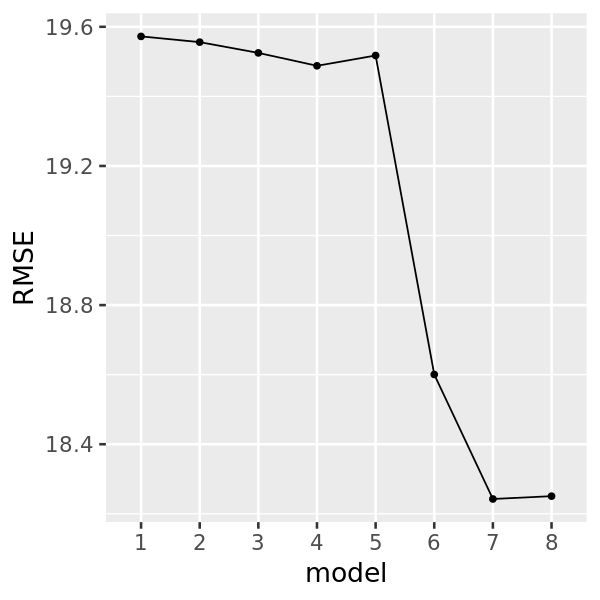

In [13]:
# adjust size of the image output
options(repr.plot.width=5, repr.plot.height=5)

cv_fit %>% ggplot(aes(x=model, y=RMSE, group=1)) +
             geom_line() +
             geom_point() +
             theme_grey(base_size=16)

We can see that `model7` has the lowest RMSE, consistent with our previous conclusion using the one-time training/test split dataset

#### 2. AIC criterion

The cross validation can be done for different number of groups and if the number of folds is maximum $k = n - 1$, where $n$ is the number of samples, this is known as leave-one-out cross validation (LOOCV)

![predict_loocv.png](images/predict_loocv.png)

As $n \to \infty$, the estimate of the LOOCV prediction error is given by the Akaike information criterion (AIC)

$$
\mathit{AIC} \approx n\log\left(\frac{RSS}{n}\right) + 2p
$$

$$
\begin{align}
\text{where } n &= \text{number of samples}\\
p &= \text{number of parameters}\\
RSS &= \text{residual sum of squares}
\end{align}
$$

We can obtain the AIC score using the `AIC` function
- `AIC(model)`

In [14]:
# collect AIC values from all 8 models for full dataset

AIC_fit <- tibble(
             model=1:8,
             formula=c(model1$call$formula,
                       model2$call$formula,
                       model3$call$formula,
                       model4$call$formula,
                       model5$call$formula,
                       model6$call$formula,
                       model7$call$formula,
                       model8$call$formula),
              AIC=c(AIC(model1),
                    AIC(model2),
                    AIC(model3),
                    AIC(model4),
                    AIC(model5),
                    AIC(model6),
                    AIC(model7),
                    AIC(model8))
                 ) %>%
            mutate(model=as.factor(model),
                  formula=as.character(formula))

AIC_fit

model,formula,AIC
<fct>,<chr>,<dbl>
1,sysBP ~ age,23345.72
2,sysBP ~ age + sex,23347.21
3,sysBP ~ age + sex + education,23342.60
4,sysBP ~ age + sex + education + glucose,23322.29
5,sysBP ~ age + sex + glucose,23326.48
6,sysBP ~ age + sex + glucose + BMI,23070.40
7,sysBP ~ age + sex + totChol + BMI + heartRate + glucose,22962.39
8,sysBP ~ .,22965.75


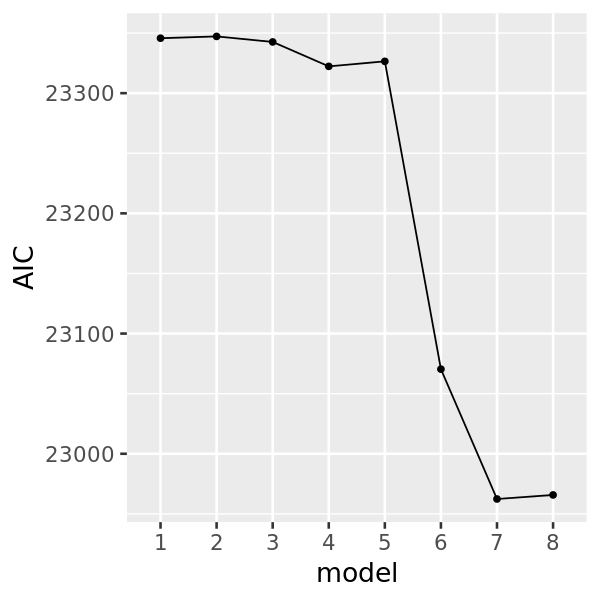

In [15]:
# adjust size of the image output
options(repr.plot.width=5, repr.plot.height=5)

AIC_fit %>% ggplot(aes(x=model, y=AIC, group=1)) +
              geom_line() +
              geom_point() +
              theme_grey(base_size=16)

We can see that `model7` has the lowest AIC, indicating that it is likely to have lower out-of-sample predictive error that the other models. This is consistent with the 10-fold cross validation result as well as the prediction error from the one-time train/test dataset split

---
## Application: Building a predictive model and plotting

Now that we have an idea how we can evaluate the predictive out-of-sample error for a model, we will consider how we search for the set of covariates for prediction. There are several strategies
- Forward stepwise selection
- Backward stepwise selection
- Best subset selection

For stepwise selections, covariates are added or removed one at a time based on a criteria (e.g. only covariates with significant p-values are retained). However, this is not recommended as the resultant model often has poor predictive performance

### 1. Selection of covariates based on AIC

Here, we will demonstrate best subset selection, whereby combinations of covariates are evaluated (in this case, using AIC). To do this we will use the `glmulti` function from the `glmulti` library
- `level = 1` to consider only independent covariates
- `method`: `h` for exhaustive search, `g` for genetic search
- `report`: set to FALSE to suppress reports for each step
- `plotty`: set to FALSE to suppress plots for each step

Note that the search can be computationally intensive
- use exhaustive search `h` if number of covariates is small
- use genetic search `g` if number of covariates is large

In [16]:
library(tidyverse)

# read data
data<- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# rename and change data types
data <- data %>%
        rename(sex = male) %>%
        mutate(sex = as.factor(sex)) %>%
        mutate(education = as.factor(education)) %>%
        mutate(currentSmoker = as.factor(currentSmoker)) %>%
        mutate(BPMeds = as.factor(BPMeds)) %>%
        mutate(prevalentStroke = as.factor(prevalentStroke)) %>%
        mutate(prevalentHyp = as.factor(prevalentHyp)) %>%
        mutate(diabetes = as.factor(diabetes)) %>%
        mutate(TenYearCHD = as.factor(TenYearCHD))

# drop missing values
data <- data %>% drop_na

data_subset <- data %>%
               filter(BPMeds==0) %>%
               select(-TenYearCHD, -prevalentStroke, -prevalentHyp, -diaBP, -currentSmoker, -BPMeds)


Rows: 4240 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (16): male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
library(glmulti)

models <- glmulti(sysBP ~ .,              # . = consider all covariates
                  data=data_subset, 
                  level=1,                # consider only independent covariates
                  method="h",             # exhaustive search
                  report=FALSE,           # suppress messages
                  plotty=FALSE)           # suppress messages

Loading required package: rJava

Loading required package: leaps



We can look at the models evaluated with their AIC scores using the `weightable` function

In [18]:
weightable(models) %>% head(10)

,model,aic,weights
,<chr>,<dbl>,<dbl>
1,sysBP ~ 1 + sex + age + totChol + BMI + heartRate + glucose,30677.29,0.17761325
2,sysBP ~ 1 + sex + education + age + totChol + BMI + heartRate + glucose,30678.11,0.11802975
3,sysBP ~ 1 + sex + diabetes + age + totChol + BMI + heartRate + glucose,30678.69,0.08842642
4,sysBP ~ 1 + sex + age + cigsPerDay + totChol + BMI + heartRate + glucose,30679.14,0.07059790
5,sysBP ~ 1 + age + totChol + BMI + heartRate + glucose,30679.19,0.06884899
6,sysBP ~ 1 + sex + education + diabetes + age + totChol + BMI + heartRate + glucose,30679.48,0.05941903
7,sysBP ~ 1 + education + age + totChol + BMI + heartRate + glucose,30679.65,0.05456322
8,sysBP ~ 1 + sex + education + age + cigsPerDay + totChol + BMI + heartRate + glucose,30679.89,0.04835294
9,sysBP ~ 1 + age + cigsPerDay + totChol + BMI + heartRate + glucose,30680.04,0.04497316


We can pick the model with the lowest AIC by selecting `objects[[1]]` from the `glmulti` object

In [19]:
top_model <- models@objects[[1]] # top model with lowest AIC

top_model %>% broom::tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),25.29907956,3.341256428,7.571726,4.670821e-14
sex1,-1.23306570,0.625202482,-1.972266,4.865695e-02
age,0.78236573,0.037771790,20.712964,4.726352e-90
totChol,0.03521470,0.007323071,4.808734,1.582146e-06
BMI,1.40539355,0.078236370,17.963430,4.044733e-69
heartRate,0.27045117,0.026326424,10.272993,2.046549e-24
glucose,0.03723685,0.013644571,2.729060,6.382910e-03


The formula for predicting the systolic BP can be expressed as

$$
\mathit{sysBP} = 25.3 +\mathit{sex_{(0/1)}} \times -1.23 + \mathit{age} \times 0.78 + \mathit{totChol} \times 0.04 + \mathit{BMI} \times 1.41 + \mathit{heartRate} \times 0.27 + \mathit{glucose} \times 0.04
$$

Note that in a predictive model, not all coefficients will have significant p-values (p < 0.05)

### 2. Statistical plotting of coefficients

We can plot the coefficients to show the relative weights of the coefficients that contribute to the predictive model using `ggcoefstats` from `ggstatsplot`
- `sort`: set to `ascending` to sort by effect size
- `exclude.intercept`: set to TRUE to omit intercept

You can cite this package as:
     Patil, I. (2021). Visualizations with statistical details: The 'ggstatsplot' approach.
     Journal of Open Source Software, 6(61), 3167, doi:10.21105/joss.03167



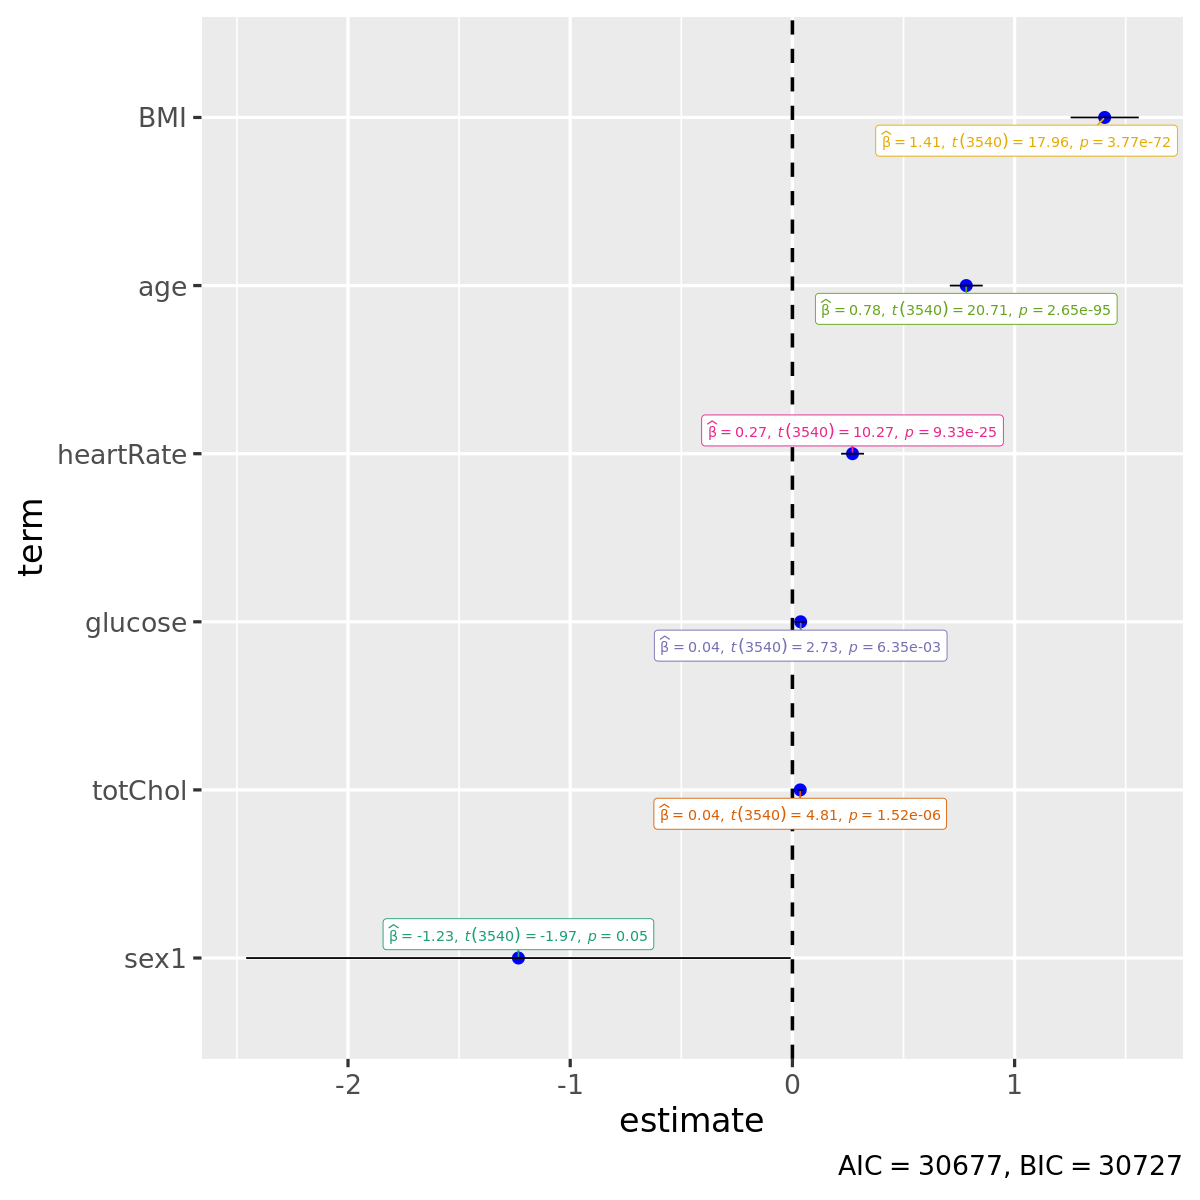

In [20]:
library(ggstatsplot)

# adjust size of the image output
options(repr.plot.width=10, repr.plot.height=10)

top_model %>% ggcoefstats(sort="ascending", 
                          exclude.intercept = TRUE) +
              theme_grey(base_size = 20)

The best subset selection approach may not be feasible with increasing number of parameters, as the total number of models to be evaluated is $2^p$. For example
- for 9 parameters in the dataset = $2^9 = 512$
- for 20 parameters = $2^{20} = 1048576$
- for 50 parameters = $2^{50} = 1125899906842624$

There are alternative regression methods that can be used fo variable selection (e.g. Ridge, LASSO, Elastic Net) but they are outside the scope of this course

---
# Exercise - Modeling for prediction

For this exercise, we will use the subset of the Framingham data `data_subset` and find the model that predicts `totChol` with the lowest AIC

In [21]:
library(tidyverse)

# read data
data<- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# rename and change data types
data <- data %>%
        rename(sex = male) %>%
        mutate(sex = as.factor(sex)) %>%
        mutate(education = as.factor(education)) %>%
        mutate(currentSmoker = as.factor(currentSmoker)) %>%
        mutate(BPMeds = as.factor(BPMeds)) %>%
        mutate(prevalentStroke = as.factor(prevalentStroke)) %>%
        mutate(prevalentHyp = as.factor(prevalentHyp)) %>%
        mutate(diabetes = as.factor(diabetes)) %>%
        mutate(TenYearCHD = as.factor(TenYearCHD))

# drop missing values
data <- data %>% drop_na

# prepare subset of data
data_subset <- data %>%
               filter(BPMeds==0) %>%
               select(-TenYearCHD, -prevalentStroke, -prevalentHyp, -diaBP, -currentSmoker, -BPMeds)

head(data_subset)

Rows: 4240 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (16): male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sex,age,education,cigsPerDay,diabetes,totChol,sysBP,BMI,heartRate,glucose
<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,39,4,0,0,195,106.0,26.97,80,77
0,46,2,0,0,250,121.0,28.73,95,76
1,48,1,20,0,245,127.5,25.34,75,70
0,61,3,30,0,225,150.0,28.58,65,103
0,46,3,23,0,285,130.0,23.10,85,85
0,43,2,0,0,228,180.0,30.30,77,99


### Part 1

Use `glmulti` to do a best subset selection of covariates and find the top model with the lowest AIC that predicts `totChol`
- Store the results of the `glmulti` best subsets selection in `my_models`
- Inspect the top 10 models using `weightable`
- Store the model with the lowest AIC in `my_top_model`
- Print the top model with `broom::tidy`

In [22]:
library(glmulti)

# start here

In [23]:
# solution

library(glmulti)

my_models <- glmulti(totChol ~ .,              # . = consider all covariates
                  data=data_subset, 
                  level=1,                # consider only independent covariates
                  method="h",             # exhaustive search
                  report=FALSE,           # suppress messages
                  plotty=FALSE)           # suppress messages

weightable(my_models) %>% head(10)

my_top_model <- my_models@objects[[1]]

my_top_model %>% broom::tidy()

,model,aic,weights
,<chr>,<dbl>,<dbl>
1,totChol ~ 1 + sex + education + age + cigsPerDay + sysBP + BMI + heartRate,36535.41,0.448623015
2,totChol ~ 1 + sex + education + age + cigsPerDay + sysBP + BMI + heartRate + glucose,36537.25,0.178791795
3,totChol ~ 1 + sex + education + diabetes + age + cigsPerDay + sysBP + BMI + heartRate,36537.40,0.165098241
4,totChol ~ 1 + sex + education + diabetes + age + cigsPerDay + sysBP + BMI + heartRate + glucose,36539.18,0.068054519
5,totChol ~ 1 + sex + age + cigsPerDay + sysBP + BMI + heartRate,36539.95,0.046128611
6,totChol ~ 1 + sex + age + cigsPerDay + sysBP + BMI + heartRate + glucose,36541.78,0.018559577
7,totChol ~ 1 + sex + diabetes + age + cigsPerDay + sysBP + BMI + heartRate,36541.95,0.017023842
8,totChol ~ 1 + sex + education + age + sysBP + BMI + heartRate,36541.98,0.016755020
9,totChol ~ 1 + sex + education + age + sysBP + BMI + heartRate + glucose,36543.69,0.007133634


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),113.8290528,7.75899885,14.670585,2.384013e-47
sex1,-6.0739199,1.53543384,-3.955833,7.776392e-05
education2,3.7887521,1.73243683,2.186950,2.881148e-02
education3,5.2297499,2.06161340,2.536727,1.123206e-02
education4,5.6922220,2.36553669,2.406313,1.616542e-02
age,1.2585000,0.09213703,13.659004,1.971854e-41
cigsPerDay,0.1869214,0.06388416,2.925942,3.456008e-03
sysBP,0.1854999,0.03822853,4.852394,1.272473e-06
BMI,0.7246850,0.18871204,3.840163,1.251061e-04


### Part 2

Plot the coefficients using `ggcoeftstats`. You may exclude the intercept
- Comment on the covariates that have the largest contribution to the prediction model

In [24]:
library(ggstatsplot)

# start here

Number of labels is greater than default palette color count.
• Select another color `palette` (and/or `package`).


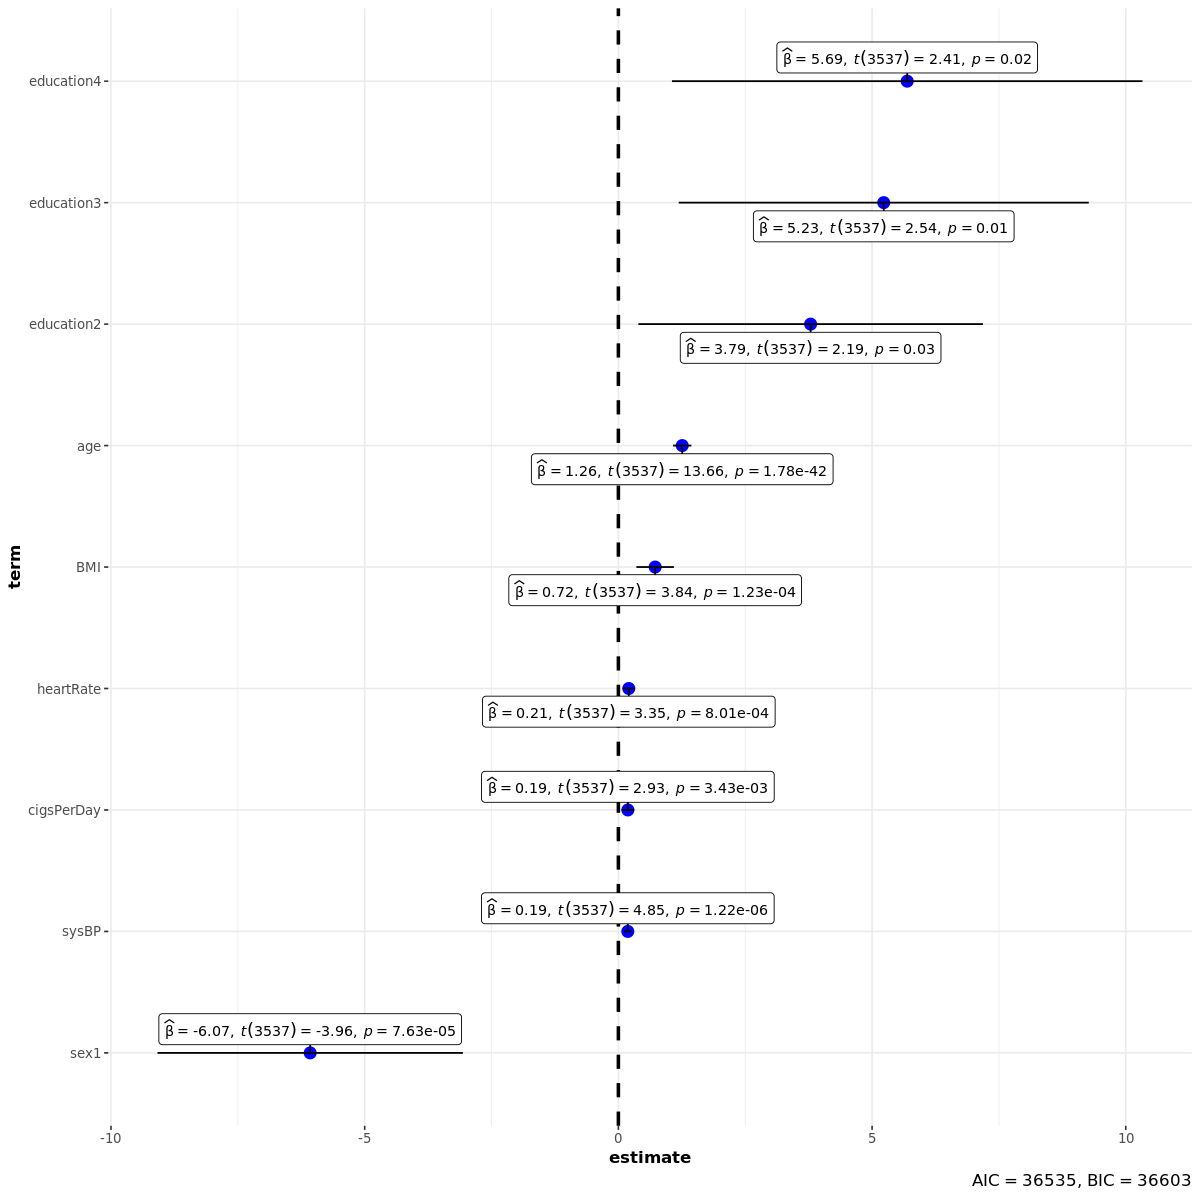

In [25]:
# solution

library(ggstatsplot)

my_top_model %>% ggcoefstats(sort="ascending",
                             exclude.intercept=TRUE)